# Viewer for plotting waterfall plots of XRD from SACLA 25 Fitzgerald beamtime
created: 2025/11  
creator: t.stevens  
other requirements: SACLA_XRD_functions.py

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from SACLA_XRD_functions import *
# import tifffile as tif
# %matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# From here should be the same
# fpd1_map = np.load('fpd1_map.npy')
fpd1_map = np.ones((1548, 2064))

# fpd1_mask = np.load('fpd1_mask.npy')
fpd1_mask = np.load('run_1620771_mask.npy')

fpd1_poni = pyFAI.load('run_1620787_7.065keV.poni')
# fpd1_PONI = pyFAI.load('fpd1_r35.poni')  # Put new poni files in here

In [19]:
# Number of scattering angle bins
npt_rad = 2000
# Number of azimuthal angle bins
npt_azim = 360
# Range for the integration in 2 theta or A^-1
radial_range = [1.5, 5]  # I suggest [0, 90] or [0,15] when changing units
# Range for the integration in azimuth
azim_range = [15, 160]
# Units of the integration    Either "2th_deg" or "q_A^-1"  You need to change the radial rangne values as well as the string below
units="q_A^-1"

pyFAI_dict = {}
pyFAI_dict['poni'], pyFAI_dict['mask'], pyFAI_dict['map'], pyFAI_dict['npt_rad'], pyFAI_dict['npt_azim'], pyFAI_dict['radial_range'], pyFAI_dict['azim_range'], pyFAI_dict['units'] = fpd1_poni, fpd1_mask, fpd1_map, npt_rad, npt_azim, radial_range, azim_range, units

In [211]:
processed_runs = {} # Run this cell once to set up cache.

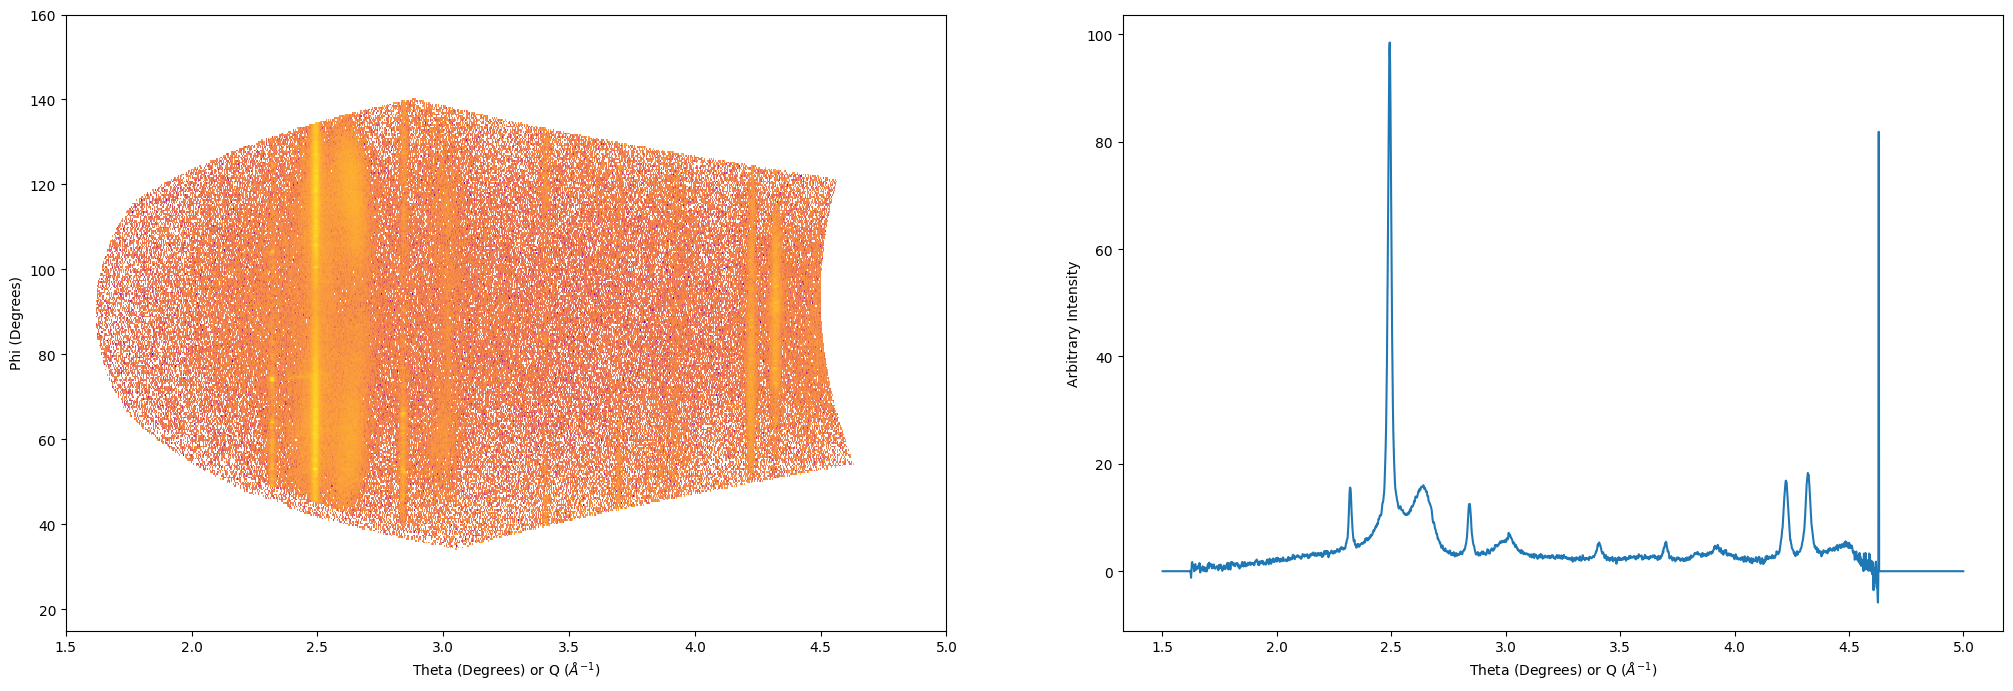

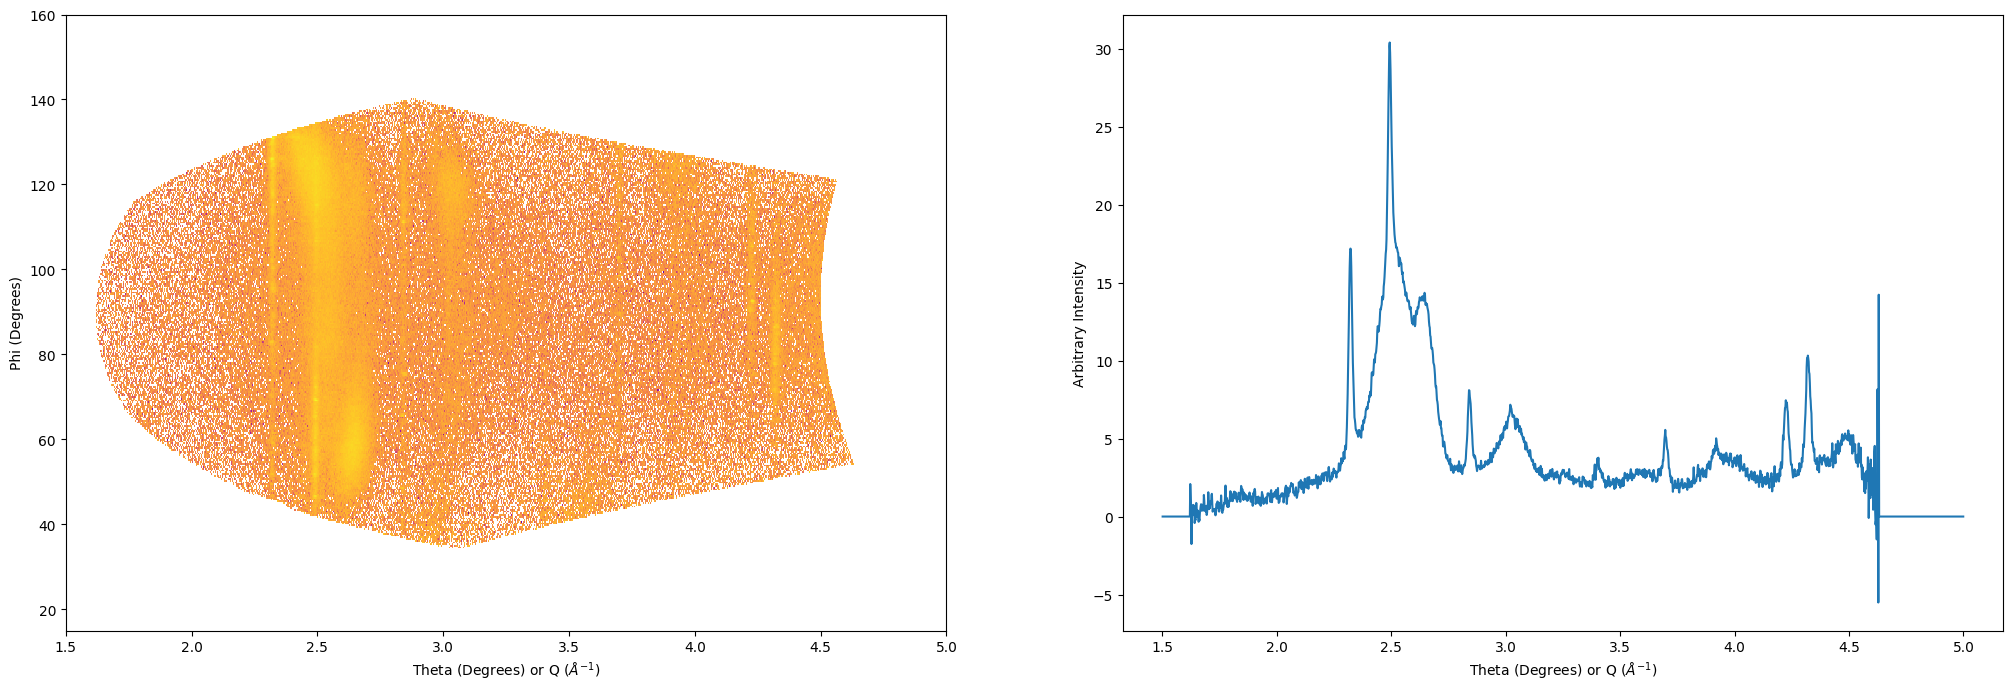

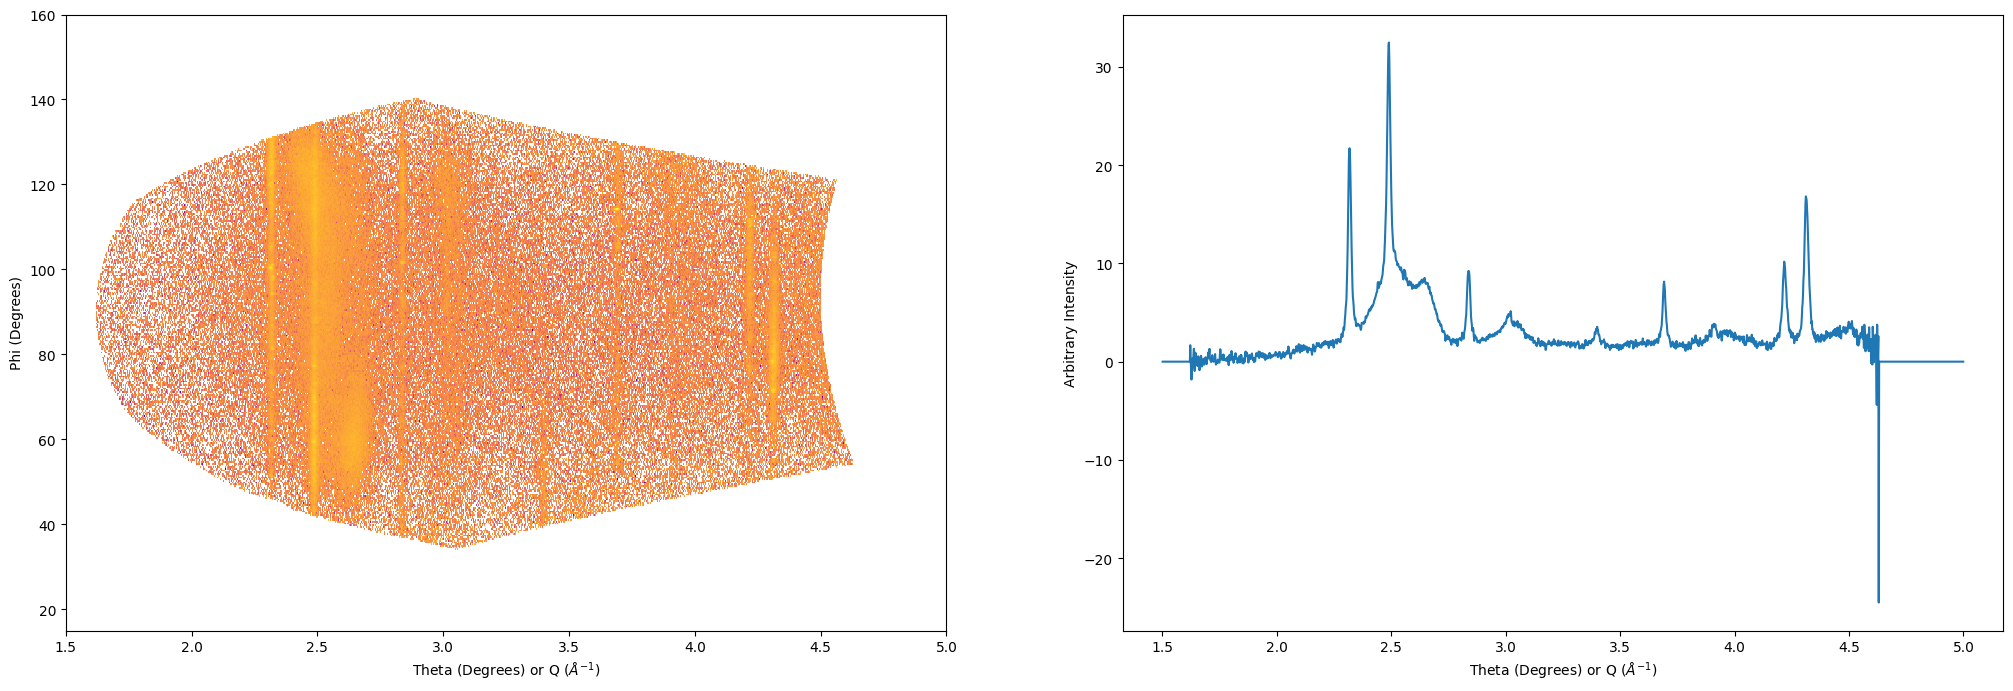

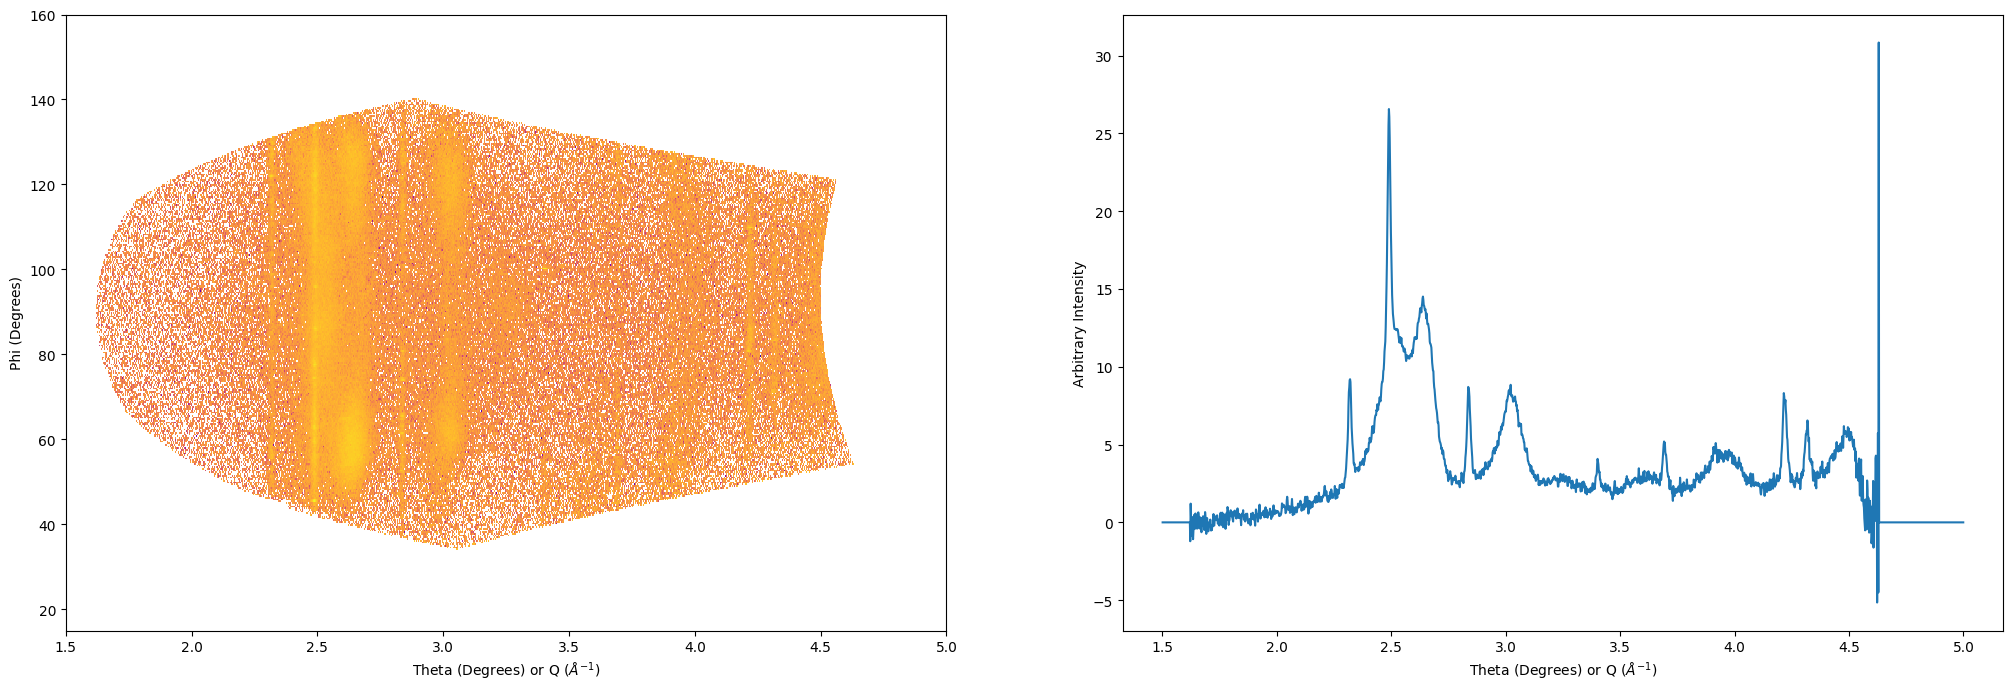

In [278]:
run_numbers = [1621033, 1621464, 1621466, 1621468, 1621470, 1621472, 1621474, 1621476, 1621478, 1621480, 1621482, 1621484, 1621486, 1621488, 1621490,
              1621492, 1621494, 1621496, 1621498]
# Put the runs you consider to be good below, also include them above.
good_runs = [1621033]
processed_runs, new_runs, fpd1_INTs, fpd1_INTs_no_offset, fpd1_INT = process_many_for_waterfall(pyFAI_dict, processed_runs, run_numbers, good_runs, export=True, plot_good=True)

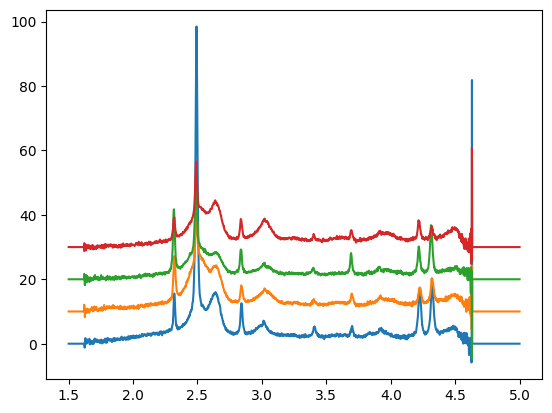

In [279]:
# Plotting just the good runs and new runs
count=0
offset=10
for run_number in good_runs:
    plt.plot(processed_runs[run_number]['INT'].radial, processed_runs[run_number]['INT'].intensity+count*offset)
    count+=1
for run_number in new_runs:
    plt.plot(processed_runs[run_number]['INT'].radial, processed_runs[run_number]['INT'].intensity+count*offset)
    count+=1

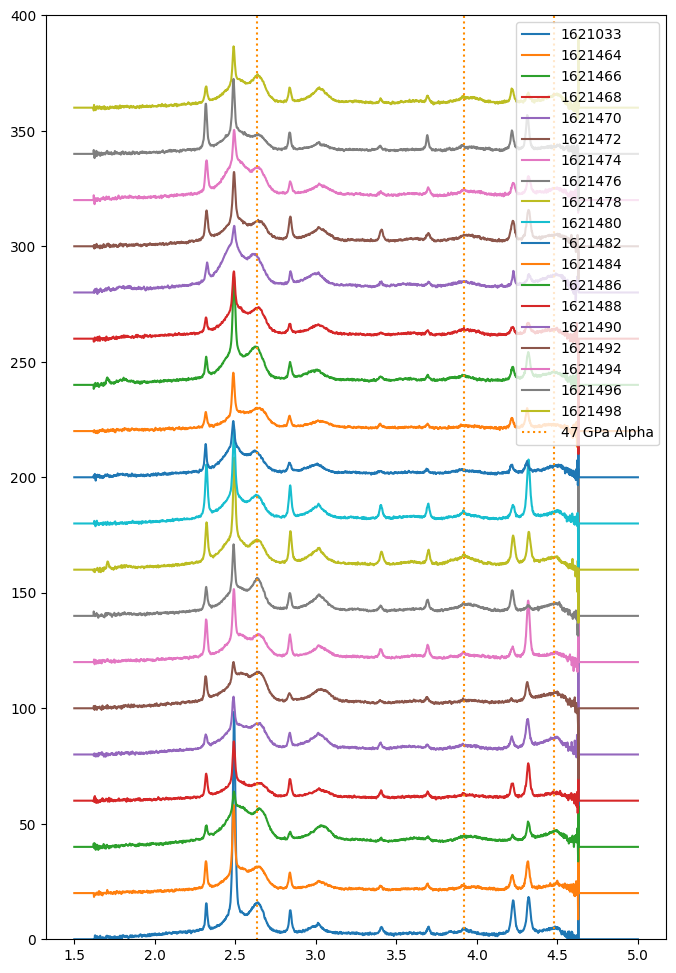

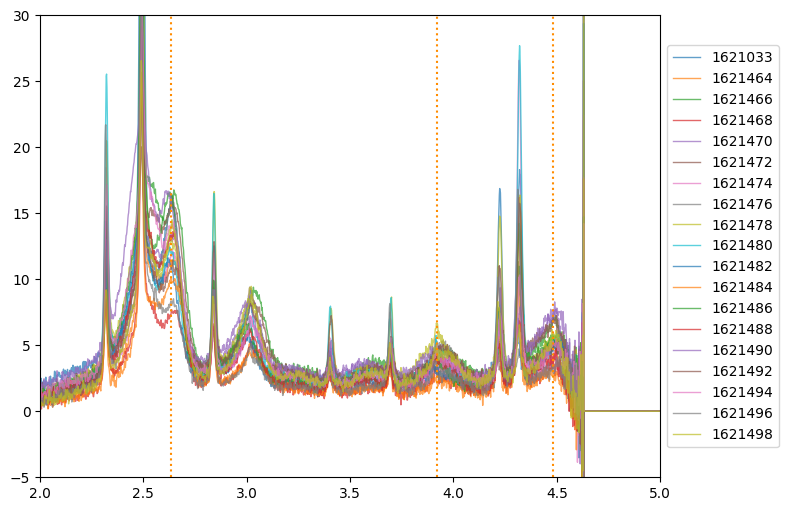

In [280]:
# Plotting all runs
plt.figure(figsize=(8,12))
plt.plot(fpd1_INT.radial, np.transpose(fpd1_INTs), label=run_numbers)
plt.vlines([2.635, 3.92, 4.48], -5, 400, label='47 GPa Alpha', color='darkorange', linestyle=':')
plt.legend()
plt.ylim(0, 400)
plt.show()
# Plotting all runs
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ax.plot(fpd1_INT.radial, np.transpose(fpd1_INTs_no_offset), label=run_numbers, alpha=0.7, linewidth=1)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(-5, 30)
ax.set_xlim(2, 5)

plt.vlines([2.635, 3.92, 4.48], -5, 100, label='47 GPa Alpha', color='darkorange', linestyle=':')

plt.show()

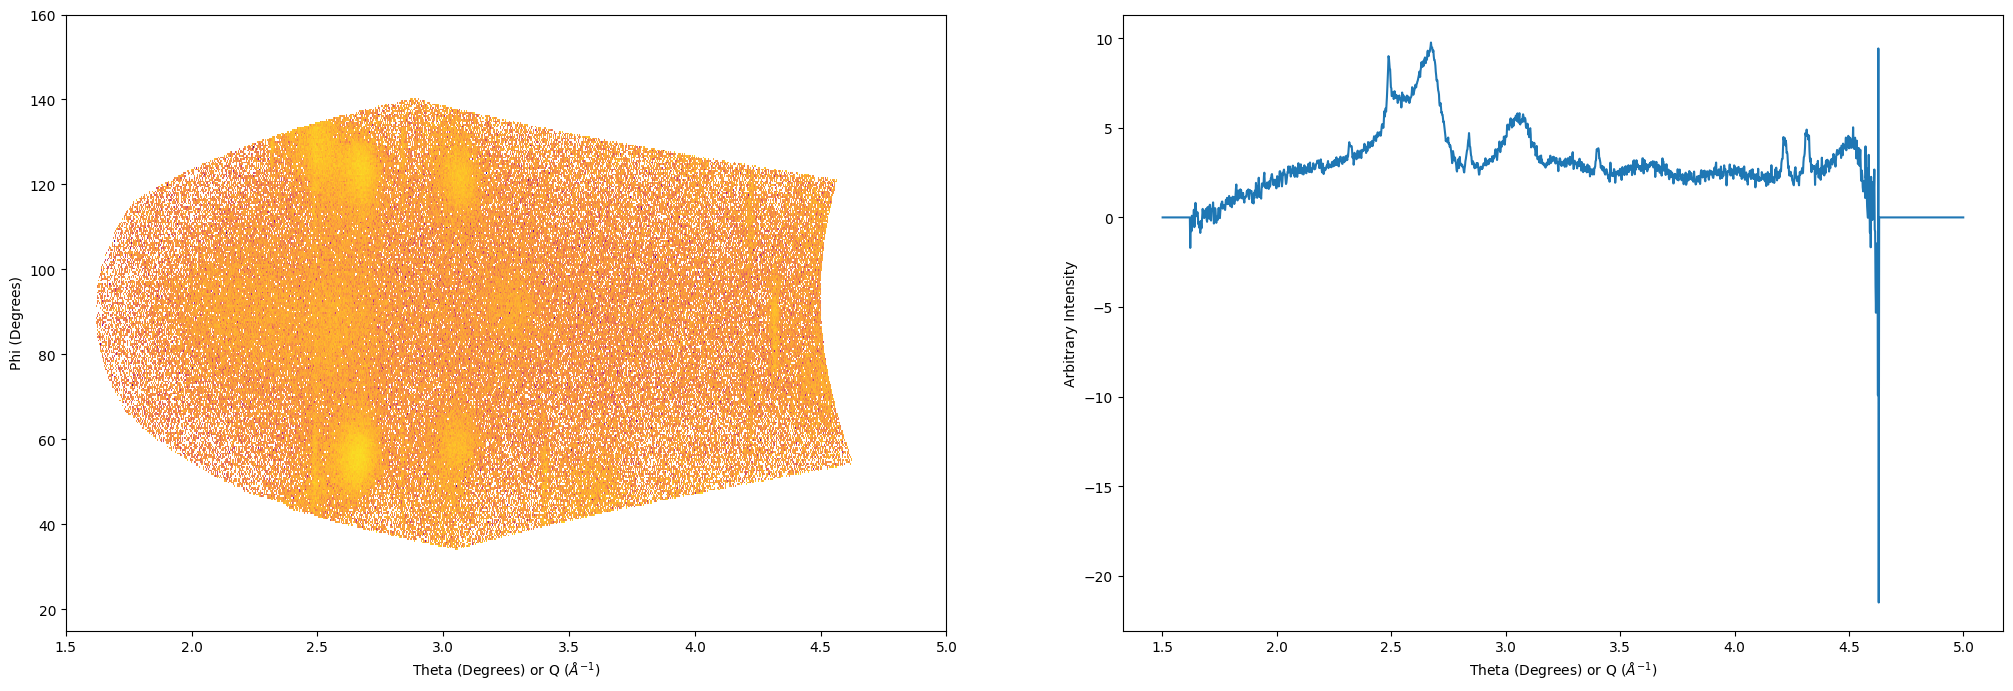

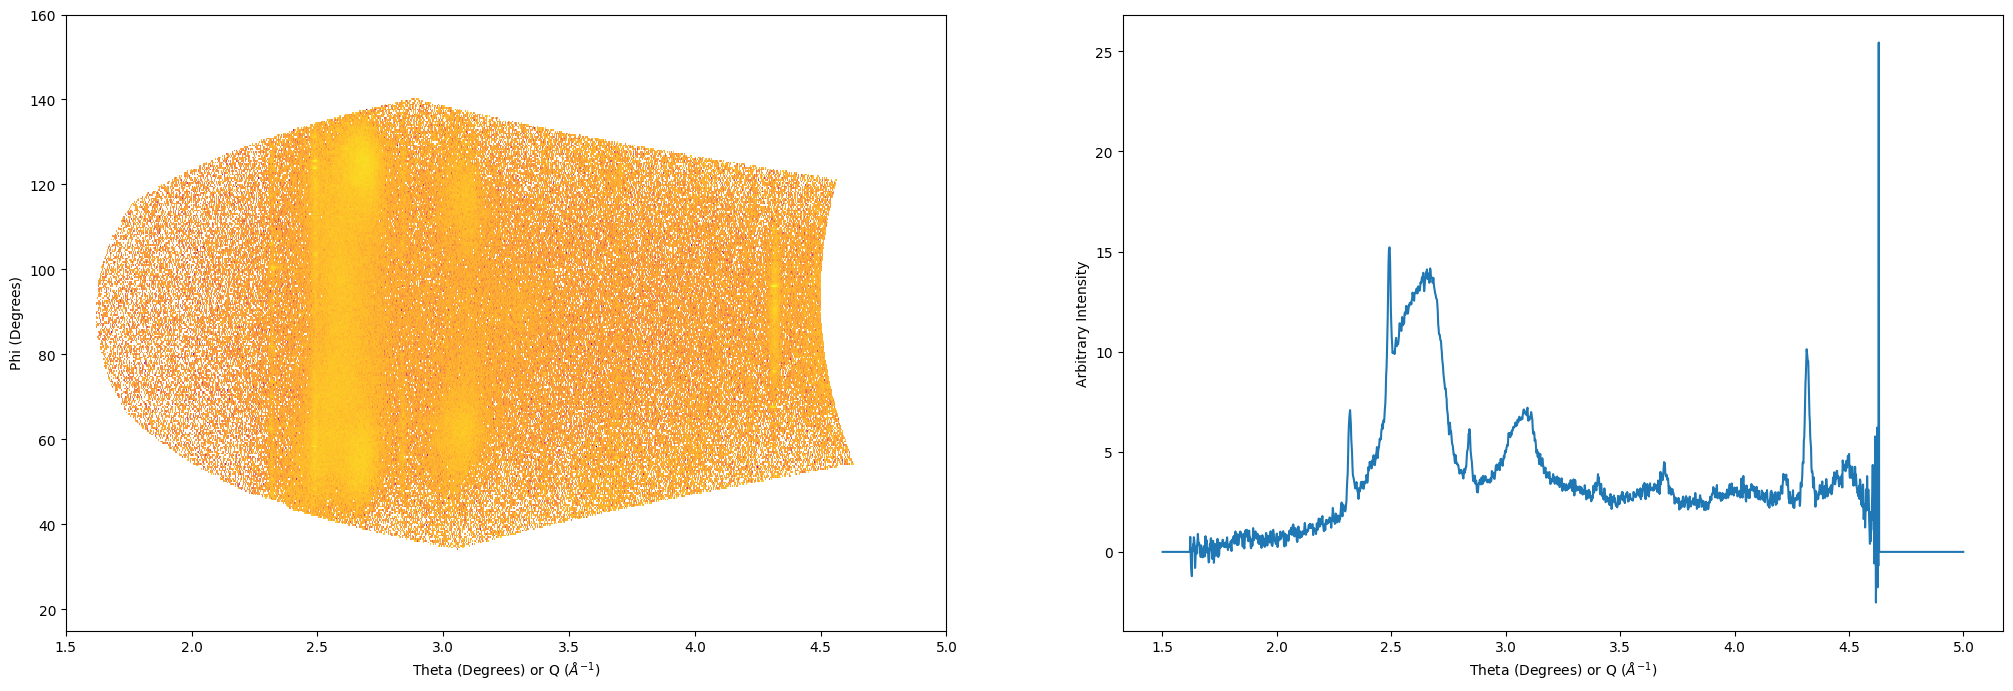

In [230]:
processed_runs_2 = {}
run_numbers = [1621460, 1621448]
# Put the runs you consider to be good below, also include them above.
good_runs = []
processed_runs_2, new_runs, fpd1_INTs, fpd1_INTs_no_offset, fpd1_INT = process_many_for_waterfall(pyFAI_dict, processed_runs_2, run_numbers, good_runs, export=True, plot_good=False)

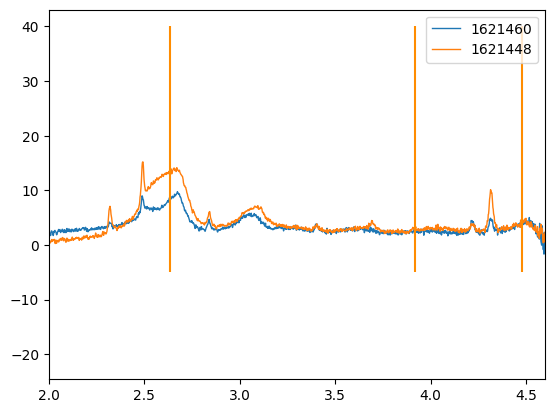

In [231]:
# Plotting just the good runs and new runs
count=0
offset=0
for run_number in new_runs:
    plt.plot(processed_runs_2[run_number]['INT'].radial, processed_runs_2[run_number]['INT'].intensity+count*offset, linewidth=1, label=run_number)
    count+=1
plt.legend()
# plt.ylim(0, 800)
plt.xlim(2, 4.6)
plt.vlines([2.635, 3.92, 4.48], -5, 40, label='47 GPa Alpha', color='darkorange')